In [9]:
## Post-processing of single interferogram from ISCE/stripmapApp.py
# 1. extract metadata from ISCE xml file into PYSAR/ROIPAC format
# 2. load geometry files into geometryRadar.h5 for geocoding
# 3. geocodeing
# 4. select reference point and masking

% matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from pysar.utils import readfile, writefile, utils as ut

work_dir = os.path.expanduser("~/insarlab/Shuangyu/KoaeCskDT165")
date12 = "20120507_20120624"

#work_dir = os.path.expanduser("~/insarlab/Shuangyu/KoaeCskAT10")
#date12 = "20120529_20120617"

os.chdir(work_dir)
print('Go to directory:', work_dir)
geom_dir = os.path.join(work_dir, 'geometry')
geom_file = os.path.join(geom_dir, 'geometryRadar.h5')
ifg_dir = os.path.join(work_dir, 'interferogram')
geo_dir = os.path.join(work_dir, 'GEOCODE')
if not os.path.isdir(geo_dir):
    os.makedirs(geo_dir)
    print('create directory:', geo_dir)

# manual setup
SNWE = "19.325 19.365 -155.31 -155.26"
ref_lat = "19.332"
ref_lon = "-155.308"

# auto setup
unw_file = 'geo_{}.unw'.format(date12)
con_file = 'geo_{}.unw.conncomp'.format(date12)
cor_file = 'geo_{}.cor'.format(date12)
in_files  = [os.path.join(ifg_dir, i) for i in ['filt_topophase.unw', 'filt_topophase.unw.conncomp', 'phsig.cor']]
out_files = [os.path.join(geo_dir, i) for i in [unw_file, con_file, cor_file]]

Go to directory: /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165


In [2]:
## prepare
## 1. Load ISCE/stripmapApp.py geometry file into geometryRadar.h5 file
if not os.path.isfile(geom_file):
    # prepare metadata
    xml_file = '{}_slc_crop.xml'.format(date12.split('_')[0])
    cmd = 'prep_isce.py -m {} -g ./geometry'.format(xml_file)
    print(cmd)
    !{cmd}

    # load into HDF5 file
    lat_file = 'geometry/lat.rdr'
    lon_file = 'geometry/lon.rdr'
    los_file = 'geometry/los.rdr'
    meta = readfile.read_attribute(lat_file)
    dsDict = {}
    dsDict['latitude'] = readfile.read(lat_file)[0]
    dsDict['longitude'] = readfile.read(lon_file)[0]
    dsDict['incidenceAngle'] = readfile.read(los_file, datasetName='incidenceAngle')[0]
    writefile.write(dsDict, out_file=geom_file, metadata=meta)
else:
    print('{} exists.'.format(geom_file))

## 2. update metadata for ifgram files
for in_file in in_files:
    atr = readfile.read_roipac_rsc('data.rsc')
    atr.update(readfile.read_isce_xml(in_file+'.xml'))
    writefile.write_roipac_rsc(atr, in_file+'.rsc', print_msg=True)

/Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/geometry/geometryRadar.h5 exists.
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw.rsc
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw.conncomp.rsc
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/phsig.cor.rsc


In [3]:
# geocoding
for in_file, out_file in zip(in_files, out_files):
    cmd = "geocode.py {} -l {} -b {} -o {}".format(in_file, geom_file, SNWE, out_file)
    print(cmd)
    !{cmd}

geocode.py /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw -l /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/geometry/geometryRadar.h5 -b 19.325 19.365 -155.31 -155.26 -o /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw
output pixel size in (lat, lon) in degree: (-5.6940109238430984e-05, 4.126538554693922e-05)
output area extent in (S N W E) in degree: (19.325, 19.365, -155.31, -155.26)
--------------------------------------------------
resampling file: /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw
reading filt_topophase from filt_topophase.unw ...
nearest resampling with kd_tree (1 segments) ...
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw.rsc
time used: 00 mins 1.8 secs.

geocode.py /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw.co

In [4]:
## select reference point
unw_file = out_files[0]
cmd = 'reference_point.py {} --lat {} --lon {} --write-data'.format(unw_file, ref_lat, ref_lon)
print(cmd)
!{cmd}

# mask
unw_file = '{}_seeded.unw'.format(os.path.splitext(out_files[0])[0])
cor_file = out_files[2]
cmd = 'mask.py {} -m {} -t 0.4'.format(unw_file, cor_file)
print(cmd)
!{cmd}

reference_point.py /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw --lat 19.332 --lon -155.308 --write-data
--------------------------------------------------
input reference point in lat/lon: (19.332, -155.308)
input reference point in y/x: (580, 49)
--------------------------------------------------
writing >>> /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw
writing /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw.rsc
Done.
mask.py /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw -m /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.cor -t 0.4
mask out pixels with value < 0.4 in mask file
masking geo_20120507_20120624_seeded from /Users/yunjunz/insarlab/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw ...
wr

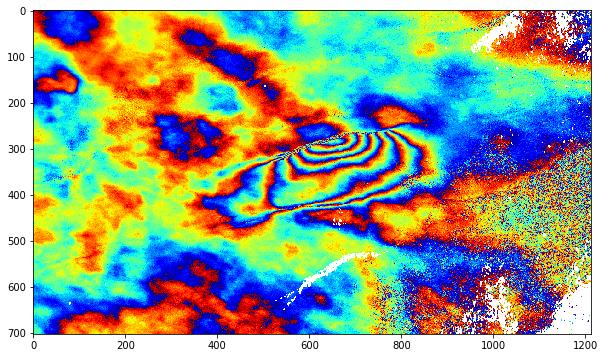

In [12]:
unw_file = '{}_seeded_masked.unw'.format(os.path.splitext(out_files[0])[0])
data = readfile.read(unw_file)[0]

plt.figure(figsize=[10, 6])
plt.imshow(ut.wrap(data), cmap='jet', vmin=-np.pi, vmax=np.pi)
plt.show()